In [20]:
import numpy as np
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [3]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [4]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)

    ### END CODE HERE ###
    return X

In [5]:
# GRADED FUNCTION: ResNet50


# GRADED FUNCTION: ResNet50

def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [6]:
model = ResNet50(input_shape = (350,250, 1), classes = 2)

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
train=np.empty(shape=(530,350,250))
y=[]
counter=0
i = 0
for filename in glob.iglob('/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/*.*'):
    print(filename)
    img=scipy.misc.imread(filename,mode='L')
    img=scipy.misc.imresize(img,(350,250))
    train[counter]=img
    counter+=1
    y.append(0)
    i += 1
for filename in glob.iglob('/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/*.*'):
    print(filename)
    img=scipy.misc.imread(filename,mode='L')
    img=scipy.misc.imresize(img,(350,250))
    train[counter]=img
    counter+=1
    y.append(1)
    i += 1

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L1.png


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L10.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L100.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L101.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L102.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L103.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L104.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L105.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L106.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L107.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_R

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L175.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L176.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L177.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L178.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L179.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L18.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L180.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L181.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L182.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_R

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L253.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L254.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L255.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L256.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L257.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L258.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L26.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L27.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L28.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Res

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L93.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L94.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L95.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L96.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L97.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L98.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Non_Diabetes/L99.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L1'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L1.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Pro

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L100.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L101'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L101.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L102'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L102.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L103'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L103.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L104'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L104.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Resea

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L14'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L14.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L140.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L141.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L15'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L15.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L16'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L16.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L17'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Pro

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L51.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L52'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L52.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L53'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L53.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L54'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L54.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L55'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L55.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Progr

/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L94'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L94.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L95'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L95.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L96'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L96.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L97'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L97.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Programs/Diab_global/L98'.png
/Users/siddhantbansal/Desktop/Python/Personal_Projects/Diabetes_Research/Prog

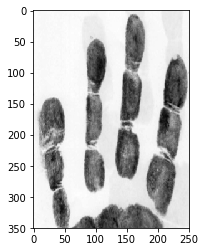

In [9]:
plt.imshow(train[529], cmap = 'gray')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)

In [12]:
Y_train = keras.utils.np_utils.to_categorical(y_train, 2)
Y_test = keras.utils.np_utils.to_categorical(y_test, 2)

In [13]:
X_train = X_train.reshape(371, 350, 250, 1)
X_test = X_test.reshape(159, 350, 250, 1)
print('Shape of training data is:',X_train.shape)
print('Length of training labels is:',(Y_train.shape))
print('Shape of test data is:',X_test.shape)
print('Length of test data is:',(Y_test.shape))

Shape of training data is: (371, 350, 250, 1)
Length of training labels is: (371, 2)
Shape of test data is: (159, 350, 250, 1)
Length of test data is: (159, 2)


In [14]:
model.fit(X_train, Y_train, epochs = 1, batch_size = 10)

Epoch 1/1
371/371 [==============================] - 1006s 3s/step - loss: 8.0755 - acc: 0.4852


In [15]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

159/159 [==============================] - 120s 754ms/step
Loss = 8.569625227706238
Test Accuracy = 0.46540880165759874
